# Généralisation robuste de LDA/QDA

Andrew Wang

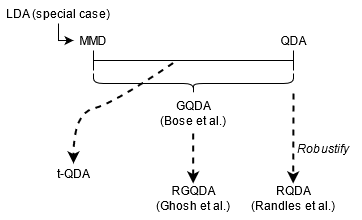

Méthodes classiques: MMD, (LDA,) QDA  
Méthodes génerales: GQDA (qui généralise le regle de classification pour les distributions ES avec la variable c qui interpole entre 0 (MMD) et 1 (QDA))  
Méthodes robustes: RQDA (utilisant le regle QDA mais avec estimation robuste - on peut compter M-estimator, MVE, MCD, etc.)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RGQDA  
Cas particulier: t-QDA (la variable c calculée en termes de DOFs, estimation robuste avec EM)  

QDA avec ES: estimation des parametres avec le meme EM (mais avec E-step fixé) et calculation des posteriors avec le E-step

In [5]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math

# PLOT:
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA
from sklearn import discriminant_analysis

# EMBEDDINGs:
import umap

In [6]:
from scipy import stats, special, optimize

In [7]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
r = robjects.r
psych = importr('psych')
rrcov = importr('rrcov')
SpatialNP = importr('SpatialNP')

In [8]:
from import_subset_datasets import *
from clustering_accuracy import acc
from vis import *

## Prepare MNIST data

In [9]:
np.random.seed(44)
random.seed(44)

read_mnist_train = pd.read_csv(r"data\mnist_train.csv")
read_mnist_test = pd.read_csv(r"data\mnist_test.csv")

In [10]:
mnist_labels_raw = read_mnist_train.iloc[:, 0]

mnist_data = read_mnist_train.iloc[:, 1:]

selected_digits = [3,6,8,9,4]
selected_digits_2 = [1,4]

mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2, pca2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [11]:
# Transform test data
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [12]:
mapper = umap.UMAP(metric='euclidean')
embedding = mapper.fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

In [13]:
ret =  lda_grid(em, mapper)

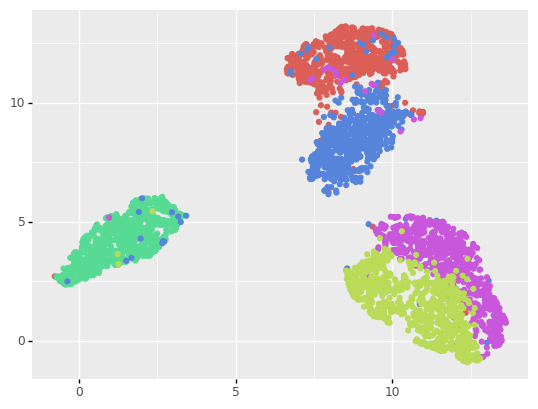

<ggplot: (160322491269)>

In [14]:
gg

## Sklearn discriminant analysis

### Sklearn LDA

In [15]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(mnist_pca, label)

LinearDiscriminantAnalysis(store_covariance=True)

(2500, 30)


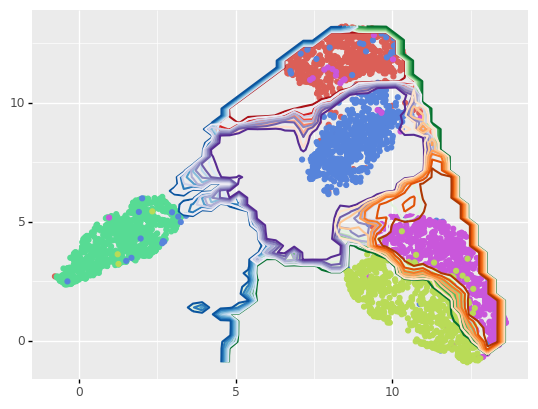

In [16]:
plot_contours_UMAP(gg, lda, *ret)

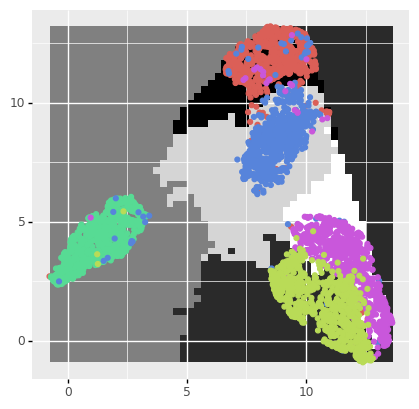

In [17]:
plot_regions_UMAP(gg, lda, *ret)

In [18]:
print_metrics(pd.Series(mnist_test_labels), lda.predict(mnist_test_pca))

Accuracy 0.908
[[366   1   7  12  14]
 [  0 368   5   3  24]
 [  0   9 384   6   1]
 [ 20   9   8 349  14]
 [  8  31   3   9 349]]


### Sklearn QDA

In [19]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), qda.predict(mnist_test_pca))

Accuracy 0.963
[[386   0   0  10   4]
 [  0 389   1   3   7]
 [  0   0 397   3   0]
 [ 14   0   1 378   7]
 [  5   6   1  12 376]]


## Implementations

### Custom LDA (with Gaussians)

In [20]:
class LDA():
    def __init__(self, method='distributional'):
        self.method = method
        self.K = None
        self.M = None
        self.ks = None #1xK
        self.priors = None #1xK
        self.coefficients = None #KxM
        self.intercepts = None #1xK
        self.parameters = None
        self.means = None #MxK
        self.covariances =  None #KxMxM
        self.pool_covs = True
        self.fudge = 1
    
    def _discriminants(self, X): #NxM -> KxN
        if (self.coefficients is None) or (self.intercepts is None):
            self.calculate_discriminant_params()
        assert((self.priors is not None) and (self.coefficients is not None) and (self.intercepts is not None))
        return self.coefficients.dot(X.T) + (self.intercepts + np.log(self.priors))[None,:].T
    
    def _bose_k(self):
        return np.array([0.5])
    
    def _mahalanobis(self, X, ki=None): #NxM -> KxN
        ret = []
        r = range(self.K) if ki is None else [ki]
        for k in r:
            m = X - self.means[:,k]
            ret += [np.diag((X - self.means[:,k]) @ np.linalg.inv(self.covariances)[k,:,:] @ (X - self.means[:,k]).T)]
        return np.vstack(ret) if ki is None else ret[0]
    
    def _general_discriminants(self, X): #KxN
        return -0.5*np.log(np.linalg.det(self.covariances))[:,None] * self.fudge - self._bose_k()[:,None] * self._mahalanobis(X)
    
    def _kth_likelihood(self, k):
        return stats.multivariate_normal(mean=self.means[:,k], cov=self.covariances[k,:,:])
    
    def _posteriors(self, X):
        r = [self._kth_likelihood(k).pdf(X) for k in range(self.means.shape[1])] #times priors!
        return np.array(r)
       
    def estimate_parameters(self, X): #NxM -> [1xM, MxM]
        return [X.mean(axis=0), np.cov(X.T)]
    
    def calculate_discriminant_params(self):
        cov_inv = np.linalg.inv(self.covariances[0,:,:])
        self.coefficients = self.means.T.dot(cov_inv)
        self.intercepts = -0.5*np.diag(self.means.T.dot(cov_inv.dot(self.means)))  
    
    def fit(self, X, y):
        self.ks = np.unique(y); self.K = len(self.ks); self.M = X.shape[1]
        classes = [X[np.where(y == k), :][0,:,:] for k in self.ks] #Kxn_kxM
        n = np.array([c.shape[0] for c in classes])
        self.parameters = [self.estimate_parameters(c) for c in classes]
        self.means = np.array([param[0] for param in self.parameters]).T
        self.covariances = np.array([param[1] for param in self.parameters])
        self.covariances = np.repeat(np.sum(n[:,None,None] * self.covariances, axis=0)[None,:],self.K,axis=0) / n.sum() \
                if self.pool_covs else self.covariances 
                    
        self.priors = n / n.sum()
        
        assert(n.sum() == X.shape[0])
        assert(self.M == self.covariances.shape[2])
        assert (self.priors.sum() == 1)
        return classes
    
    def _dk_from_method(self, X):
        if self.method=='distributional':
            return self._posteriors(X)
        elif self.method=='coeffs':
            return self._discriminants(X)
        elif self.method=='generalised':
            return self._general_discriminants(X)
                
    def predict(self, X):
        dk = self._dk_from_method(X)
        return self.ks[dk.argmax(axis=0)] 
       
    def predict_proba(self, X):
        dk = self._dk_from_method(X)
        if self.method!='distributional':
            dk = np.exp(dk)
        return (dk/dk.sum(axis=0)).T   

In [21]:
test_lda = LDA(method='generalised')

test_lda.fit(mnist_pca, mnist_labels)

print_metrics(pd.Series(mnist_test_labels), test_lda.predict(mnist_test_pca))

Accuracy 0.908
[[366   1   7  12  14]
 [  0 368   5   3  24]
 [  0   9 384   6   1]
 [ 20   9   8 349  14]
 [  8  31   3   9 349]]


### Custom QDA

In [22]:
class QDA(LDA):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.pool_covs = False

In [23]:
test_qda = QDA(method='generalised')

test_qda.fit(mnist_pca, mnist_labels)

print_metrics(pd.Series(mnist_test_labels), test_qda.predict(mnist_test_pca))

Accuracy 0.963
[[386   0   0  10   4]
 [  0 389   1   3   7]
 [  0   0 397   3   0]
 [ 14   0   1 378   7]
 [  5   6   1  12 376]]


### t-LDA fitting (mostly redundant: pooling covs still means discriminant depends on x^2 because of differing dofs (assuming same dofs = MMD classifier)

In [24]:
def fit_t(X, iter=200, eps=1e-6):
    N,D = X.shape
    cov = np.cov(X,rowvar=False)
    mean = X.mean(axis=0)
    mu = X - mean[None,:]
    dof = 3
    obj = []

    for i in range(iter):
        # E step
        delta = np.einsum('ij,ij->i', mu, np.linalg.solve(cov,mu.T).T)
        z = (dof + D) / (dof + delta)
        
        obj.append(
            -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 \
            -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(np.log(z)-z).sum()/2)
        if len(obj) > 1 and np.abs(obj[-1] - obj[-2]) < eps: break
        
        # M step
        mean = (X * z[:,None]).sum(axis=0).reshape(-1,1) / z.sum()
        mu = X - mean.squeeze()[None,:]
        cov = np.einsum('ij,ik->jk', mu, mu * z[:,None])/N
        d_t = (np.log(z) + special.digamma((dof + D)/2) - np.log((dof + D)/2) - z).sum()
        dof_obj = lambda v: -( -N*special.gammaln(v/2) + N*v*np.log(v/2)/2 + v*d_t/2 )
        dof_grad = lambda v: -(N/2 * (-special.digamma(v/2) + np.log(v/2) + 1) + d_t/2)        
        dof = optimize.minimize(dof_obj, dof, jac=dof_grad, bounds=[(0,None)]).x

    return mean.squeeze(), cov, dof

In [25]:
class t_LDA(LDA):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.dofs = None #1xK
    
    def _kth_likelihood(self, k):
        return stats.multivariate_t(loc=self.means[:,k], shape=self.covariances[k,:,:], df=self.dofs[k])
    
    def estimate_parameters(self, X):
        return fit_t(X)
    
    def _bose_k(self):
        return (0.5*(1 + self.M/self.dofs))
    
    def _discriminants(self, X): #NxM -> KxN
        return None
        
    def _general_discriminants(self, X):
        v = self.dofs
        return super()._general_discriminants(X) + (special.gammaln((v+self.M)/2) - special.gammaln(v/2) - 0.5*self.M*np.log(v))[:,None]
            
    def fit(self, X,y):
        super().fit(X,y)
        self.dofs = np.array([param[2] for param in self.parameters]).squeeze()

In [26]:
test_t_lda = t_LDA(method='generalised')

test_t_lda.fit(mnist_pca, mnist_labels)
#test_t_lda.dofs = np.ones((test_t_lda.K)) * 0.5
print_metrics(pd.Series(mnist_test_labels), test_t_lda.predict(mnist_test_pca))

Accuracy 0.7195
[[388   8   2   2   0]
 [  0 399   0   1   0]
 [  7  93 296   4   0]
 [ 76  48   1 275   0]
 [ 13 300   1   5  81]]


### t-QDA

In [27]:
class t_QDA(t_LDA):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.pool_covs = False

In [28]:
test_t_qda = t_QDA(method='generalised')

test_t_qda.fit(mnist_pca, mnist_labels)

print_metrics(pd.Series(mnist_test_labels), test_t_qda.predict(mnist_test_pca))

Accuracy 0.8735
[[396   0   0   4   0]
 [  3 396   0   1   0]
 [ 15  10 364  11   0]
 [ 45   5   0 350   0]
 [ 17 128   0  14 241]]


(2500, 30)


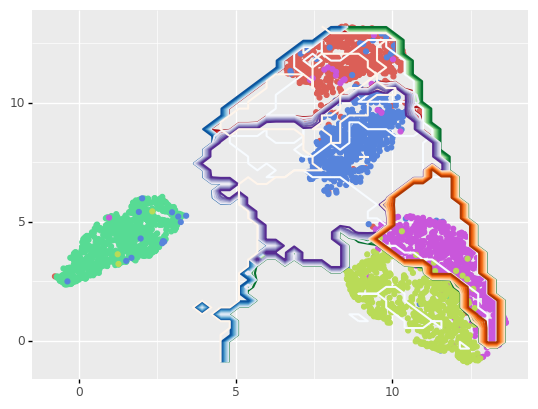

In [29]:
plot_contours_UMAP(gg, test_t_qda, *ret)

### GQDA selon Bose et al.

In [30]:
class GQDA(QDA):
    def __init__(self):
        super().__init__(method='generalised')
        self.c = None
    
    def fit(self, X,y,c=None):
        classes = super().fit(X,y) #Kx[n_k, M]
        
        if c is not None:
            self.c = c
            return 
            
        uijs = [np.zeros((classes[k].shape[0], self.K, self.K)) for k in range(self.K)] #Kx[n_kxIxJ]
        sij = np.zeros((self.K,self.K))
        logdets = np.log(np.linalg.det(self.covariances)) #K,  
        for i in range(self.K):
            for j in range(self.K):
                dij_on_i = self._mahalanobis(classes[i], ki=j) - self._mahalanobis(classes[i], ki=i) #Kxn_i
                dij_on_j = self._mahalanobis(classes[j], ki=j) - self._mahalanobis(classes[j], ki=i) #Kxn_j
                sij[i,j] = logdets[j] - logdets[i]
                
                
                uijs[i][:, i, j] = dij_on_i / sij[i,j]
                uijs[i][:, j, j] = np.inf
                uijs[j][:, i, j] = dij_on_j / sij[i,j]
        
        T = []
        for uij in uijs:
            T.append(uij[(uij > 0) * (uij<1)])
        T = np.sort(np.concatenate(T))
        T = np.concatenate([np.array([0]), T])
        #print(T)
        MCc = np.zeros((len(T)))
        for e,c in enumerate(T):
            
            for i in range(self.K):
                Rijc = []
                for j in range(self.K):
                    if i==j: continue
                    p = uijs[i][:, i,j]
                    to_app = p > -c if sij[i,j]>0 else p < -c 
                    Rijc.append(classes[i][to_app])
                Rijc = np.vstack(Rijc)
                Ric = np.unique(Rijc, axis=0)
                #print(Ric.shape, Rijc.shape)
                lenRic = Ric.shape[0]
                MCic = classes[i].shape[0] - lenRic
                #print(MCic, Ric.shape)
                MCc[e] += MCic
                
        #return uijs, MCc, T
        c_star = T[MCc.argmin()]
        self.c = c_star if c_star > 0 else 0.001
        print("optimal c is", c_star)
        
    def _bose_k(self):
        return np.array([0.5/self.c])
        
        #def predict(self, X):
        

In [31]:
test_gqda = GQDA()
test_gqda.fit(mnist_pca, mnist_labels)

<ipython-input-30-68ace3946e77>:23: RuntimeWarning: invalid value encountered in true_divide
<ipython-input-30-68ace3946e77>:25: RuntimeWarning: invalid value encountered in true_divide


optimal c is 0.7772200700306124


In [32]:
print_metrics(pd.Series(mnist_test_labels), test_gqda.predict(mnist_test_pca))

Accuracy 0.964
[[386   0   0  10   4]
 [  0 390   1   4   5]
 [  0   0 397   3   0]
 [ 12   0   1 380   7]
 [  4   7   1  13 375]]


### RGQDA (becomes classical QDA with robust estimator if c=1) 

In [33]:
class RGQDA(GQDA):
    def __init__(self, estimation='gaussian'):
        super().__init__()
        self.estimation = estimation
        
    def estimate_parameters(self, X): #NxM -> [1xM, MxM]
        if self.estimation == 'gaussian':
            return self.estimate_gaussian_MLE(X)
        elif self.estimation == 't-EM':
            return self.estimate_t_EM(X)
        elif self.estimation == 'winsorised':
            return self.estimate_winsorised(X)
        elif self.estimation == 'MVE':
            return self.estimate_MVE(X)
        elif self.estimation == 'MCD':
            return self.estimate_MCD(X)
        elif self.estimation == 'M-estimator':
            return self.estimate_M_estimator(X)
        elif self.estimation == 'S-estimator':
            return self.estimate_S_estimator(X)
        elif self.estimation == 'SD-estimator':
            return self.estimate_SD_estimator(X)

    def estimate_t_EM(self, X):
        return fit_t(X) #discarding dof parameters

    def estimate_gaussian_MLE(self, X):
        return [X.mean(axis=0), np.cov(X.T)]

    def _get_r_frame(self, X):
        return pandas2ri.py2rpy(pd.DataFrame(X))

    def estimate_winsorised(self, X):
        frame = self._get_r_frame(X)
        winsorised = psych.winsor(frame, trim=0.1)
        return self.estimate_gaussian_MLE(winsorised)

    def estimate_MVE(self, X):
        frame = self._get_r_frame(X)
        MVE = rrcov.CovMve(frame, alpha=0.5)
        return [MVE.slots['center'], MVE.slots['cov']]

    def estimate_MCD(self, X):
        frame = self._get_r_frame(X)
        MCD = rrcov.CovMcd(frame, alpha=0.5)
        return [MCD.slots['center'], MCD.slots['cov']]   
    
    def estimate_S_estimator(self, X):
        frame = self._get_r_frame(X)
        S = rrcov.CovSest(frame)
        return [S.slots['center'], S.slots['cov']]  

    def estimate_SD_estimator(self, X):
        frame = self._get_r_frame(X)
        SD = rrcov.CovSde(frame)
        return [SD.slots['center'], SD.slots['cov']] 
    
    def estimate_M_estimator(self, X):
        frame = self._get_r_frame(X)
        M = SpatialNP.mvhuberM(frame)
        #print(list(M))
        return list(M)   

In [34]:
test_rgqda = RGQDA(estimation='S-estimator')
test_rgqda.fit(mnist_pca, mnist_labels)

<ipython-input-30-68ace3946e77>:23: RuntimeWarning: invalid value encountered in true_divide
<ipython-input-30-68ace3946e77>:25: RuntimeWarning: invalid value encountered in true_divide


optimal c is 0.13968597284636414


In [35]:
print_metrics(pd.Series(mnist_test_labels), test_rgqda.predict(mnist_test_pca))

Accuracy 0.946
[[386   0   0  12   2]
 [  1 394   1   2   2]
 [  2   1 388   9   0]
 [ 20   2   1 375   2]
 [ 10  23   0  18 349]]


### RQDA

In [36]:
test_rqda = RGQDA(estimation='S-estimator')
test_rqda.fit(mnist_pca, mnist_labels, c=1) #reduces to QDA with robust estimates

In [37]:
print_metrics(pd.Series(mnist_test_labels), test_rqda.predict(mnist_test_pca))

Accuracy 0.9495
[[386   0   0  11   3]
 [  0 388   2   2   8]
 [  0   1 392   7   0]
 [ 20   2   1 373   4]
 [ 11  16   0  13 360]]


In [ ]:
X1 = stats.multivariate_t(loc=np.array([1,1]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=1.5).rvs(size=1000)

In [ ]:
frame = pandas2ri.py2rpy(pd.DataFrame(X1))

In [ ]:
M = rrcov.CovSest(frame)

In [ ]:
print(list(M))

In [ ]:
result = rrcov.CovMcd(frame,alpha=0.9, nsamp=1000)

In [ ]:
M.slots['cov']

In [ ]:
fit_t(X1)[1]

## Synthetic Data

In [38]:
df=1.5
np.random.seed(seed=233423)

In [39]:
X1 = stats.multivariate_t(loc=np.array([1,1]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=df).rvs(size=1000)
X2 = stats.multivariate_t(loc=np.array([15,-4]), shape=np.array([[6, 0.5], [0.5, 7]]), df=df).rvs(size=1000)
X3 = stats.multivariate_t(loc=np.array([7,7]), shape=np.array([[3, 0], [0, 1]]), df=df).rvs(size=1000)
X = np.vstack([X1, X2, X3])

In [40]:
y = np.hstack([np.zeros((1000)), np.ones((1000)), 2*np.ones((1000))])

In [41]:
np.random.seed(seed=233424)

In [42]:
X1_test = stats.multivariate_t(loc=np.array([1,1]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=df).rvs(size=1000)
X2_test = stats.multivariate_t(loc=np.array([15,-4]), shape=np.array([[6, 0.5], [0.5, 7]]), df=df).rvs(size=1000)
X3_test = stats.multivariate_t(loc=np.array([7,7]), shape=np.array([[3, 0], [0, 1]]), df=df).rvs(size=1000)
X_test = np.vstack([X1_test, X2_test, X3_test])

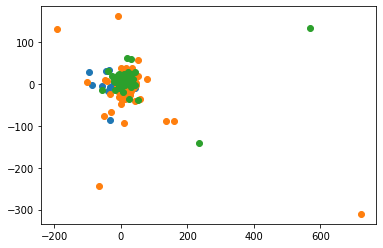

In [43]:
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.scatter(X3[:,0],X3[:,1])

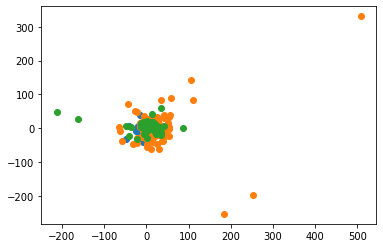

In [44]:
plt.scatter(X1_test[:,0],X1_test[:,1])
plt.scatter(X2_test[:,0],X2_test[:,1])
plt.scatter(X3_test[:,0],X3_test[:,1])

### LDA

<ipython-input-20-4cd8fe404c03>:84: RuntimeWarning: invalid value encountered in true_divide


Accuracy 0.905
[[929  13  58]
 [ 42 845 113]
 [ 44  15 941]]
[[ 0.84458702 15.5940549   7.74989923]
 [ 0.97100157 -4.60899065  7.08044246]]
[[[367.66873049 -67.84551402]
  [-67.84551402 118.47231213]]

 [[367.66873049 -67.84551402]
  [-67.84551402 118.47231213]]

 [[367.66873049 -67.84551402]
  [-67.84551402 118.47231213]]]


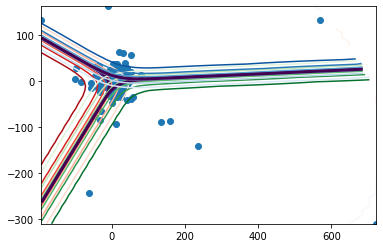

In [45]:
ldatest = LDA(method='generalised')#discriminant_analysis.LinearDiscriminantAnalysis()
ldatest.fit(X, pd.Series(y))
plt.scatter(X[:,0],X[:,1])
plot_contours(X, ldatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), ldatest.predict(X_test))
print(ldatest.means)
print(ldatest.covariances)

### QDA

Accuracy 0.631
[[961  18  21]
 [247 601 152]
 [656  13 331]]
[[ 0.84458702 15.5940549   7.74989923]
 [ 0.97100157 -4.60899065  7.08044246]]
[[[  44.718064     -0.80249056]
  [  -0.80249056   22.04964581]]

 [[ 657.95608394 -240.46855266]
  [-240.46855266  275.89468351]]

 [[ 400.33204352   37.73450117]
  [  37.73450117   57.47260709]]]


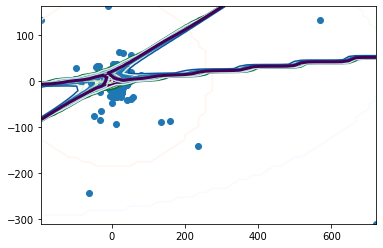

In [46]:
qdatest = QDA(method='generalised')#discriminant_analysis.QuadraticDiscriminantAnalysis()
qdatest.fit(X, pd.Series(y))
plt.scatter(X[:,0],X[:,1])
plot_contours(X, qdatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), qdatest.predict(X_test))
print(qdatest.means)
print(qdatest.covariances)

### t-LDA

<ipython-input-20-4cd8fe404c03>:84: RuntimeWarning: invalid value encountered in true_divide


Accuracy 0.9123333333333333
[[928  12  60]
 [ 48 884  68]
 [ 51  24 925]]
[[ 0.96790255 14.99332799  6.89963693]
 [ 0.95447339 -4.11036928  7.05781935]]
[[[3.79550917 0.17854252]
  [0.17854252 3.09144462]]

 [[3.79550917 0.17854252]
  [0.17854252 3.09144462]]

 [[3.79550917 0.17854252]
  [0.17854252 3.09144462]]]


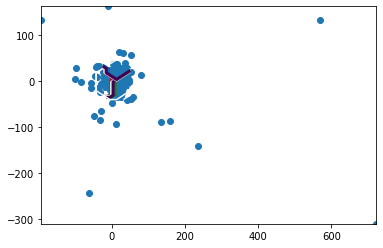

In [47]:
t_ldatest = t_LDA(method='generalised')
t_ldatest.fit(X, pd.Series(y))
plt.scatter(X[:,0],X[:,1])
plot_contours(X, t_ldatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), t_ldatest.predict(X_test))
print(t_ldatest.means)
print(t_ldatest.covariances)

### t-QDA

<ipython-input-20-4cd8fe404c03>:84: RuntimeWarning: invalid value encountered in true_divide


Accuracy 0.9196666666666666
[[902  49  49]
 [ 18 972  10]
 [ 34  81 885]]


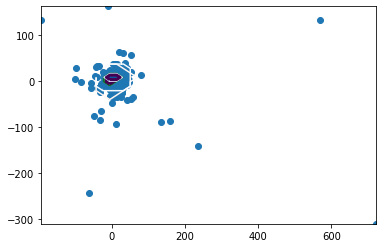

In [48]:
t_qdatest = t_QDA(method='generalised')
t_qdatest.fit(X, pd.Series(y))
plt.scatter(X[:,0],X[:,1])
plot_contours(X, t_qdatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), t_qdatest.predict(X_test)) #exact
#print(t_qdatest.covariances)

### GQDA

<ipython-input-30-68ace3946e77>:23: RuntimeWarning: invalid value encountered in true_divide
<ipython-input-30-68ace3946e77>:25: RuntimeWarning: invalid value encountered in true_divide


optimal c is 0.4767650065538315


<ipython-input-20-4cd8fe404c03>:84: RuntimeWarning: invalid value encountered in true_divide


Accuracy 0.8853333333333333
[[923  32  45]
 [ 44 852 104]
 [ 91  28 881]]


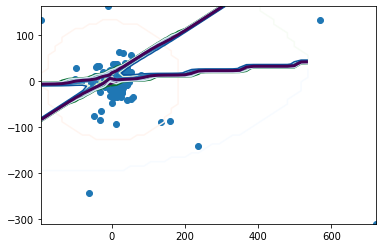

In [49]:
gqdatest = GQDA()
gqdatest.fit(X, pd.Series(y))

plt.scatter(X[:,0],X[:,1])
plot_contours(X, gqdatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), gqdatest.predict(X_test)) #exact

### RGQDA

<ipython-input-30-68ace3946e77>:23: RuntimeWarning: invalid value encountered in true_divide
<ipython-input-30-68ace3946e77>:25: RuntimeWarning: invalid value encountered in true_divide


optimal c is 0.9193151117417231


<ipython-input-20-4cd8fe404c03>:84: RuntimeWarning: invalid value encountered in true_divide


Accuracy 0.9216666666666666
[[901  46  53]
 [ 17 972  11]
 [ 33  75 892]]


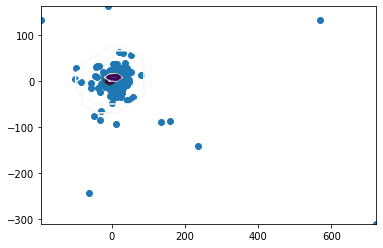

In [50]:
rgqdatest = RGQDA('M-estimator')
rgqdatest.fit(X, pd.Series(y))

plt.scatter(X[:,0],X[:,1])
plot_contours(X, rgqdatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), rgqdatest.predict(X_test)) #exact

### RQDA

<ipython-input-20-4cd8fe404c03>:84: RuntimeWarning: invalid value encountered in true_divide


Accuracy 0.9223333333333333
[[903  44  53]
 [ 18 971  11]
 [ 34  73 893]]


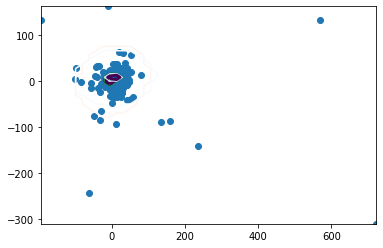

In [51]:
rqdatest = RGQDA('M-estimator')
rqdatest.fit(X, pd.Series(y), c=1)

plt.scatter(X[:,0],X[:,1])
plot_contours(X, rqdatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), rqdatest.predict(X_test)) #exact

## NORB test

### Prepare NORB data

In [1]:
from smallnorb import *

In [4]:
NORB = SmallNORBDataset(dataset_root='data/')

datiss = NORB._parse_NORB_dat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')
NORB_datos = np.reshape(datiss, (48600, 9216,)) #each image in a row
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

Loading categories...: 100%|██████████| 24300/24300 [00:00<00:00, 777659.33it/s]


In [53]:
np.random.seed(44)
random.seed(44)

#categories = ['human', 'airplane', 'truck', 'car']
selected_cat = [1, 2, 3, 4]
n_sample = 400
n_pca = 30

#NORB_norm = NORB_datos_lt - NORB_datos_lt.mean(axis=1).reshape(-1, 1) 

NORB_datos_lt = pd.DataFrame(NORB_datos_lt)
#NORB_datos_lt = pd.DataFrame(NORB_norm)

NORB_pca, NORB_labels_sel, NORB_raw, ve, _ = import_subset(NORB_datos_lt, NORB_labels, selected_cat, 30, 400)

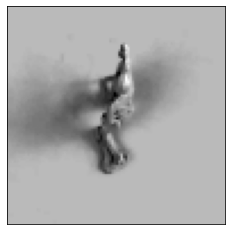

In [54]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow(np.reshape(1-np.array(NORB_raw.iloc[100])/255, (96, 96)), cmap="binary")

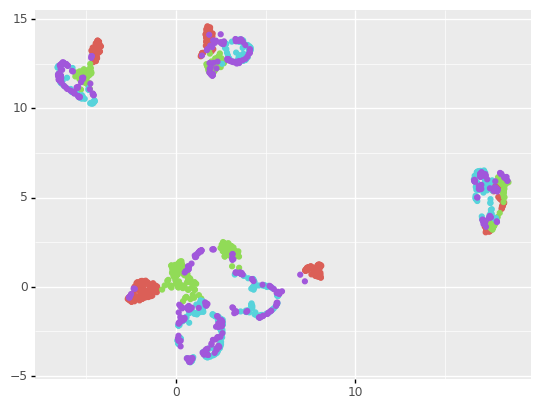

<ggplot: (160333458592)>

In [63]:
norb_embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(NORB_pca)

norb_label = pd.Series(NORB_labels_sel)
norb_em = pd.DataFrame(norb_embedding, columns=['A','B']) 
norb_em['labels'] = norb_label.astype(str)
norb_gg = ggplot(aes(x='A', y='B', color='labels'), data=norb_em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)
norb_gg

### Test implementations

In [64]:
norb_ldatest = LDA(method='generalised')#discriminant_analysis.LinearDiscriminantAnalysis()
norb_ldatest.fit(NORB_pca, NORB_labels_sel)
print_metrics(norb_label, norb_ldatest.predict(NORB_pca))

Accuracy 0.7925
[[359  37   0   4]
 [  1 330  29  40]
 [  0  53 321  26]
 [  6  83  53 258]]


In [65]:
norb_qdatest = QDA(method='generalised')#discriminant_analysis.LinearDiscriminantAnalysis()
norb_qdatest.fit(NORB_pca, NORB_labels_sel)
print_metrics(norb_label, norb_qdatest.predict(NORB_pca))

Accuracy 0.95375
[[400   0   0   0]
 [  5 386   8   1]
 [  0   2 385  13]
 [  2   3  40 355]]


In [66]:
norb_t_qdatest = t_QDA(method='generalised')
norb_t_qdatest.fit(NORB_pca, NORB_labels_sel)
print_metrics(norb_label, norb_t_qdatest.predict(NORB_pca))

Accuracy 0.748125
[[184  16   0 200]
 [  0 345   2  53]
 [  0   0 269 131]
 [  0   0   1 399]]


In [68]:
norb_gqdatest = GQDA()
norb_gqdatest.fit(NORB_pca, NORB_labels_sel)
print_metrics(norb_label, norb_gqdatest.predict(NORB_pca))

<ipython-input-30-68ace3946e77>:23: RuntimeWarning: invalid value encountered in true_divide
<ipython-input-30-68ace3946e77>:25: RuntimeWarning: invalid value encountered in true_divide


optimal c is 0.611386887562409
Accuracy 0.959375
[[396   1   0   3]
 [  1 388   5   6]
 [  0   2 378  20]
 [  0   1  26 373]]


In [69]:
norb_rgqdatest = RGQDA(estimation='M-estimator')
norb_rgqdatest.fit(NORB_pca, NORB_labels_sel)
print_metrics(norb_label, norb_rgqdatest.predict(NORB_pca))

<ipython-input-30-68ace3946e77>:23: RuntimeWarning: invalid value encountered in true_divide
<ipython-input-30-68ace3946e77>:25: RuntimeWarning: invalid value encountered in true_divide


optimal c is 0.7839613320231557
Accuracy 0.955625
[[386   5   0   9]
 [  1 394   4   1]
 [  0   2 381  17]
 [  0   2  30 368]]


In [70]:
norb_rqdatest = RGQDA(estimation='M-estimator')
norb_rqdatest.fit(NORB_pca, NORB_labels_sel, c=1)
print_metrics(norb_label, norb_rqdatest.predict(NORB_pca))

Accuracy 0.95
[[390   4   0   6]
 [  3 391   5   1]
 [  0   2 383  15]
 [  1   4  39 356]]


In [ ]:
for c in np.linspace(0.01,1,100):
    test_gqda.c = c
    accuracies += [acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))]

In [ ]:
test_gqda.c = 1
test_gqda.fudge = 0
acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))

In [ ]:
plt.scatter(X[:,0],X[:,1])
plot_contours(X, test_gqda.predict_proba, plt.gca())